In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from src.create_ARX_model import ARXModel
from src.simulate_real_system import simulate_real_system

In [3]:
outflow_model = ARXModel(A = np.array([[5.9998E-01],  
                                       [4.8249E-02]]),
                                       
                         B = np.array([[4.4071E-01]]).T,

                         C = np.array([-2.8262E+02]))

In [4]:
# MPC parameters
horizon = 300

# Define symbolic variables
u = ca.SX.sym('u', horizon)    # Input
y = ca.SX.sym('y', horizon)  # Output
y_ref = ca.SX.sym('y_ref')  # Constant reference trajectory
y_past_initial = ca.SX.sym('y_past_initial', 2)  #TODO: The number of lags should be consistent with the shape of A
u_past_initial = ca.SX.sym('u_past_initial', 1) 

# Cost function and constraints
cost = 0
constraints = []

for k in range(horizon):
    # Update past values
    y_past, u_past = outflow_model.update_past_values(k, y, u, y_past_initial, u_past_initial) 
    y_next = outflow_model.arx_model(y_past, u_past)

    # Add to cost function
    cost += 50*(y[k] - y_ref)**2 + 0.2*u[k]**2

    # Add constraint
    constraints.append(y[k] - y_next)


In [5]:

# Define the optimization problem
nlp = {
    'f': cost,
    'x': ca.vertcat(u, y),
    'g': ca.vertcat(*constraints),
    'p': ca.vertcat(y_ref, y_past_initial, u_past_initial)
}

# Solver options
opts = {
    'ipopt.print_level': 0,  # Suppress IPOPT output
    'print_time': 0          # Suppress solver timing information
}

In [6]:
sim_steps  = 60
initial_y_past = np.array([220, 200])
initial_u_past = np.array([200]) 
u_opt = []
y_opt = []

for step in range(sim_steps):
    # Initial guess
    if step == 0:
        updated_y_past, updated_u_past = initial_y_past, initial_u_past

    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)
    # Constant desired output value (example)
    constant_desired_output = 400

    # Solve the MPC problem
    sol = solver(
        lbx=-ca.inf, 
        ubx=ca.inf, 
        lbg=0, 
        ubg=0, 
        p=ca.vertcat(constant_desired_output, updated_y_past, updated_u_past)
    )
    
    optimal_step = sol['x'].full().flatten()[0]
    # Simulate the real system response
    updated_y_past, updated_u_past, system_reponse = simulate_real_system(updated_y_past, updated_u_past, optimal_step, step)
    u_opt.append(optimal_step)
    y_opt.append(system_reponse)




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



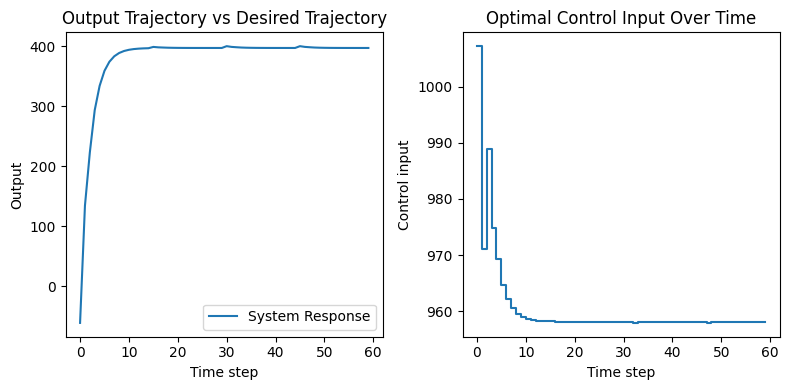

In [7]:
plt.figure(figsize=(8, 4))


# Plot for optimal outputs
plt.subplot(1, 2, 1)
plt.plot(y_opt, label='System Response')
plt.title("Output Trajectory vs Desired Trajectory")
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()

# Plot for optimal controls
plt.subplot(1, 2, 2)
plt.step(range(sim_steps), u_opt, where='post')
plt.title("Optimal Control Input Over Time")
plt.xlabel('Time step')
plt.ylabel('Control input')
plt.tight_layout()

plt.show()